<a href="https://colab.research.google.com/github/MustafaKhan670093/Autonomous-F1-Car/blob/main/Cone_Detector_With_Convex_Hulls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cone Detection Using Computer Vision**


In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = 10, 10

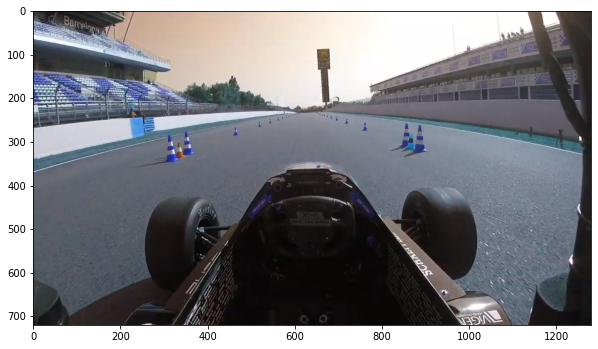

In [ ]:
# path = "/content/skidpad_1.jpg"
#path = "/content/skidpad_2.jpg"
path = "/content/accel_2.jpg"
img = cv2.imread(path)
plt.imshow(img)
plt.show()

# **Cone Detection Pipeline**

This cone detectoin pipeline uses HSV colour filtering to identify yellow, blue, and orange objects in an image. Next, median blur and morphological transformations smoothen out the image and handle the white, reflective line on each cone. Next, Canny edge detection identifies edges in the image and contour plus convex hull identification turns these edges into convex hulls. The convex hulls are passed through an image processing function that finds the nearest polygon that the convex hull approximates which simplifies the shapes under consideration. Finally, a function checks whether the convex hull is pointing up which is the defining characteristic of a traffic cone. With this, we have traffic cone detection and return the bounding boxes of the detections.

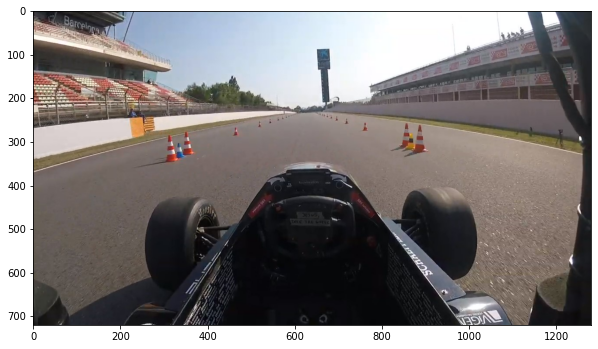

In [ ]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

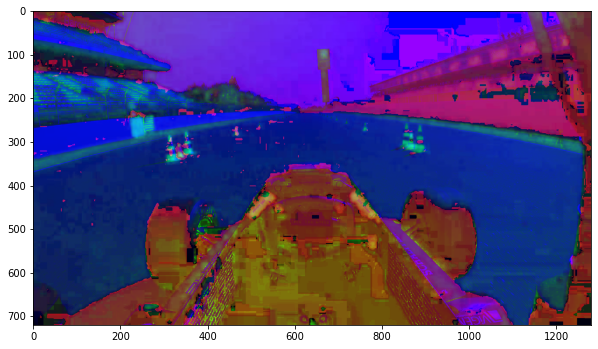

In [ ]:
hsv_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
plt.imshow(hsv_img)
plt.show()

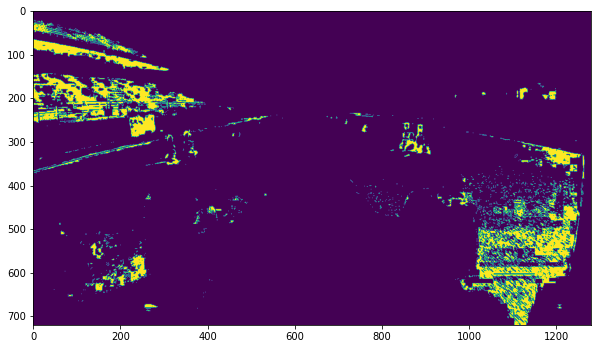

In [ ]:
# Next, we're going to take the hsv image and threshold it to identify orange, blue, and yellow items in the image
# TODO: In the future, look at  https://docs.opencv.org/3.4/da/d97/tutorial_threshold_inRange.html and see if a GUI can be
# made to quickly find low and high HSV values in the field for quick tuning and calibration.
# For now, we will manually enter values.
from google.colab.patches import cv2_imshow

ORANGE_MIN = np.array([5, 50, 50],np.uint8)
ORANGE_MAX = np.array([15, 255, 255],np.uint8)

hsv_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

frame_threshed = cv2.inRange(hsv_img, ORANGE_MIN, ORANGE_MAX)
plt.imshow(frame_threshed)
plt.show()

In [ ]:
lower_orange = np.array([0, 100, 90]) #closer to red
upper_orange = np.array([22, 255, 255]) #closer to orange

# lower_blue = np.array([101,50,70])
# upper_blue = np.array([110,255,255])

lower_blue = np.array([100,134,90])
upper_blue = np.array([130,255,255])

lower_yellow = np.array([22, 100, 90])
upper_yellow = np.array([35, 255, 255])

orange_img_threshold = cv2.inRange(hsv_img, lower_orange, upper_orange)
blue_img_threshold = cv2.inRange(hsv_img, lower_blue, upper_blue)
yellow_img_threshold = cv2.inRange(hsv_img, lower_yellow, upper_yellow)

intermediate_thresholded_img = cv2.bitwise_or(orange_img_threshold, blue_img_threshold)
thresholded_img = cv2.bitwise_or(intermediate_thresholded_img, yellow_img_threshold)

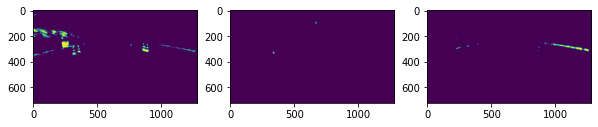

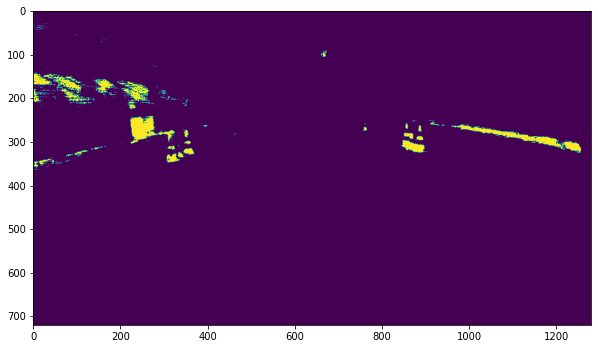

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(orange_img_threshold)
ax[1].imshow(blue_img_threshold)
ax[2].imshow(yellow_img_threshold)
plt.show()
plt.imshow(thresholded_img)
plt.show()

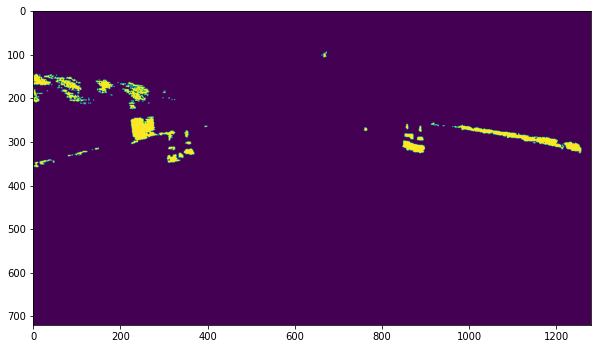

In [ ]:
#next let's see if we can make the threshold smoother/better
kernel = np.ones((2,2))
morph_open_img = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, kernel)
plt.imshow(morph_open_img) 
plt.show()

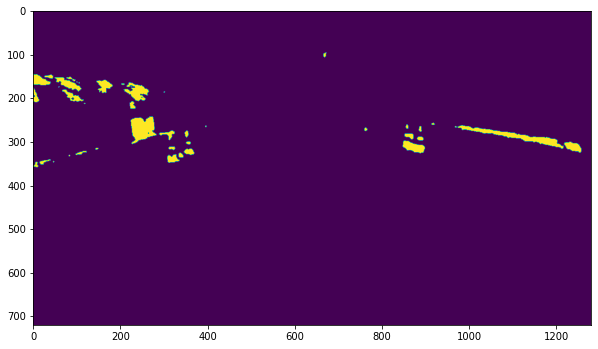

In [ ]:
median_blur_img = cv2.medianBlur(morph_open_img, 5)
plt.imshow(median_blur_img)
plt.show()

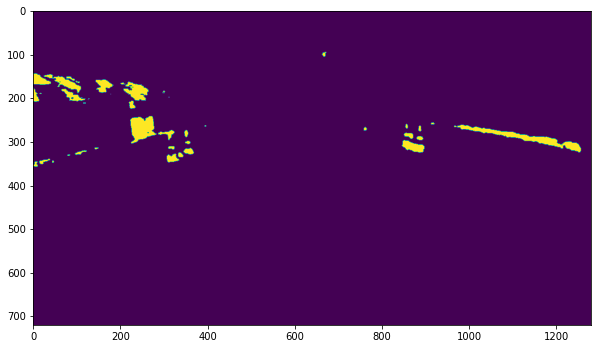

In [ ]:
#do median blur first and then morph_open
median_blur_img = cv2.medianBlur(thresholded_img, 5)
plt.imshow(median_blur_img)
plt.show()

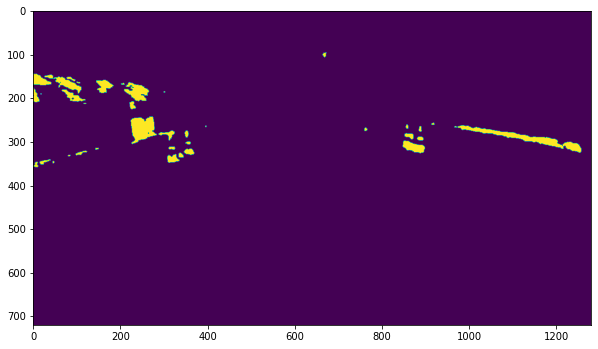

In [ ]:
#next let's see if we can make the threshold smoother/better
kernel = np.ones((2,2))
morph_open_img = cv2.morphologyEx(median_blur_img, cv2.MORPH_OPEN, kernel)
plt.imshow(morph_open_img) 
plt.show()

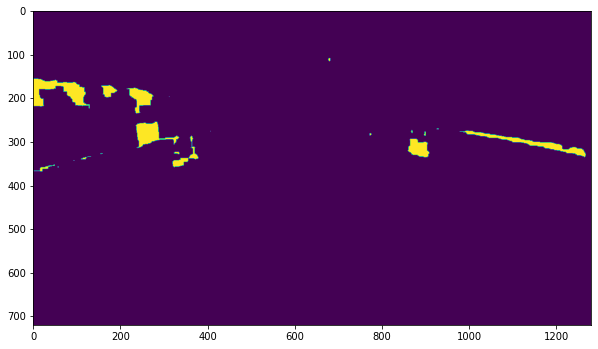

In [ ]:
### Getting rid of small artifacts by eroding first and then dilating
kernel = np.ones((2,2), np.uint8)
# threshed_img_smooth = cv2.erode(thresholded_img, kernel, iterations=2)
# threshed_img_smooth = cv2.dilate(threshed_img_smooth, kernel, iterations=2)
# plt.imshow(threshed_img_smooth)
# plt.show()

### Trying to account for reflective tape on traffic cones
### dilation bridges gap between top and bottom of cone)
#smoothed_img = cv2.dilate(threshed_img_smooth, kernel, iterations=11)
#smoothed_img = cv2.dilate(thresholded_img, kernel, iterations=8)

# # if kernel size is 3,3
# smoothed_img = cv2.dilate(morph_open_img, kernel, iterations=20)
# smoothed_img = cv2.erode(smoothed_img, kernel, iterations=20)

smoothed_img = cv2.dilate(morph_open_img, kernel, iterations=10)
smoothed_img = cv2.erode(smoothed_img, kernel, iterations=12)

# #if kernel is 2,2
# smoothed_img = cv2.dilate(median_blur_img, kernel, iterations=30)
# smoothed_img = cv2.erode(smoothed_img, kernel, iterations=30)

plt.imshow(smoothed_img)
plt.show()

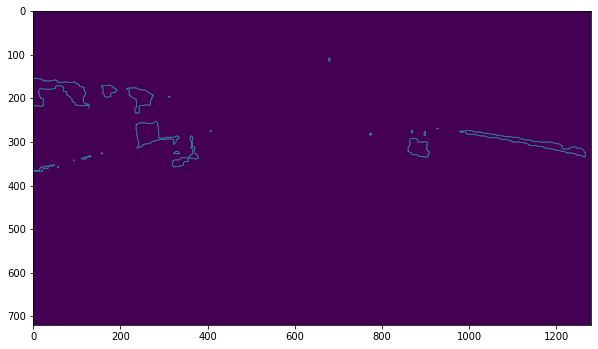

In [ ]:
#edge detection will allow us to draw lines around objects
#edges_in_img = cv2.Canny(morph_open_img, 80, 160)
edges_in_img = cv2.Canny(smoothed_img, 80, 160)
plt.imshow(edges_in_img)
plt.show()

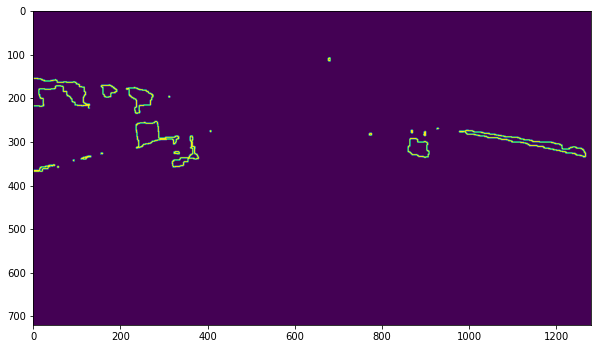

In [ ]:
contours, _ = cv2.findContours(np.array(edges_in_img), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_in_img = np.zeros_like(edges_in_img)
cv2.drawContours(contours_in_img, contours, -1, (255,255,255), 2)
plt.imshow(contours_in_img)
plt.show()

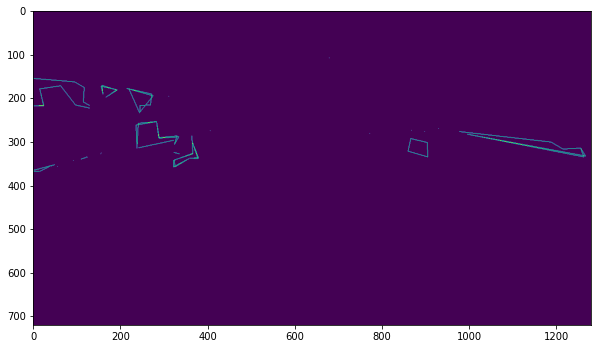

In [ ]:
approx_contours = []
for c in contours:
  approx = cv2.approxPolyDP(c, 10, closed=True)
  approx_contours.append(approx)

img_with_approx_contours = np.zeros_like(edges_in_img)
cv2.drawContours(img_with_approx_contours, approx_contours, -1, (225,225,225), 1)
plt.imshow(img_with_approx_contours)
plt.show()

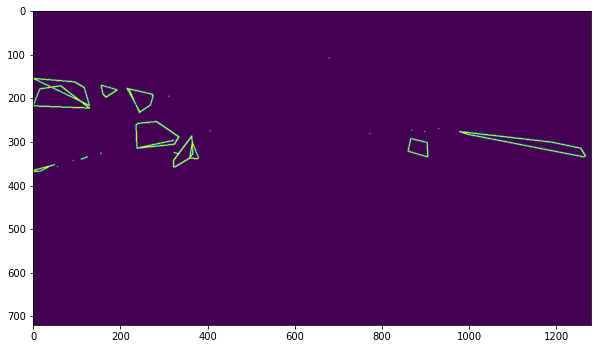

In [ ]:
all_convex_hulls = []
for ac in approx_contours:
  all_convex_hulls.append(cv2.convexHull(ac))

img_with_all_convex_hulls = np.zeros_like(edges_in_img)
cv2.drawContours(img_with_all_convex_hulls, all_convex_hulls, -1, (225,225,225), 2)
plt.imshow(img_with_all_convex_hulls)
plt.show()

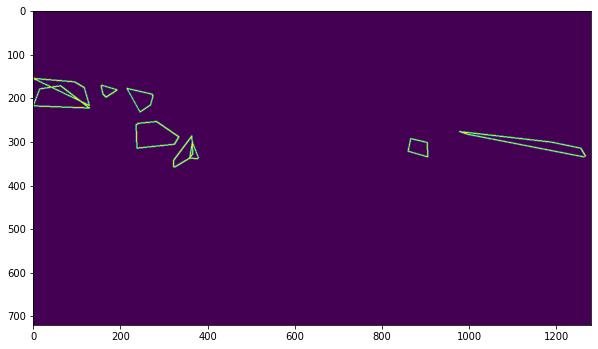

In [ ]:
filter_convex_hulls = []
for ch in all_convex_hulls:
  if 3 <= len(ch) <= 11:
    filter_convex_hulls.append(cv2.convexHull(ch))

img_with_filtered_convex_hulls = np.zeros_like(edges_in_img)
cv2.drawContours(img_with_filtered_convex_hulls, filter_convex_hulls, -1, (225,225,225), 2)
plt.imshow(img_with_filtered_convex_hulls)
plt.show()

In [ ]:
def is_convex_hull_pointing_up(ch):
  points_above_center, points_below_center = [], []
  x, y, w, h = cv2.boundingRect(ch)
  aspect_ratio = w/h

  if aspect_ratio < 0.8:
    vertical_center = y + h / 2
    for point in ch:
      if point[0][1] < vertical_center:
        points_above_center.append(point)
      elif point[0][1] >= vertical_center:
        points_below_center.append(point)
    
    left_x = points_below_center[0][0][0]
    right_x = points_below_center[0][0][0]
    for point in points_below_center:
      if point[0][0] < left_x:
        left_x = point[0][0]
      if point[0][0] > right_x:
        right_x = point[0][0]
    
    for point in points_above_center:
      if (point[0][0] < left_x) or (point[0][0] > right_x):
        return False
  else:
    return False
  return True

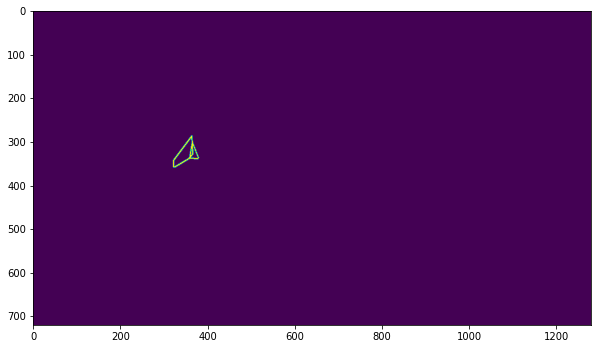

In [ ]:
#assume convex hulls filtered so far and pointing up are traffic cones
cones = []
bounding_rects = []
for ch in filter_convex_hulls:
  if is_convex_hull_pointing_up(ch) == True:
    cones.append(ch)
    rect = cv2.boundingRect(ch)
    bounding_rects.append(rect)

img_with_identified_cones = np.zeros_like(edges_in_img)
cv2.drawContours(img_with_identified_cones, cones, -1, (225,225,225), 2)
plt.imshow(img_with_identified_cones)
plt.show()

# **Output Of Pipeline**

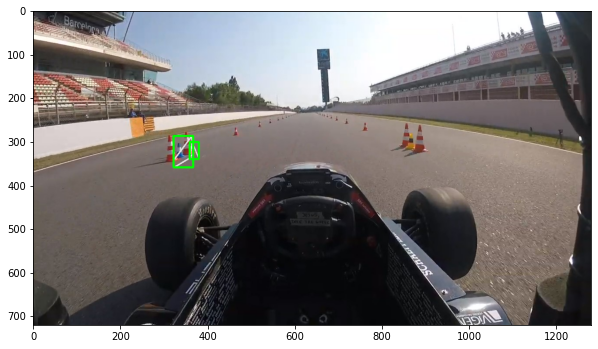

In [ ]:
img_with_bounding_boxes = img.copy()
img_with_bounding_boxes = cv2.cvtColor(img_with_bounding_boxes, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_with_bounding_boxes, cones, -1, (225,225,225), 2)

for rect in bounding_rects:
  cv2.rectangle(img_with_bounding_boxes, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (1,255,1), 3)

plt.imshow(img_with_bounding_boxes)
plt.show()

In [ ]:
print(str(len(bounding_rects)) + ' cone(s) found in the image')

2 cone(s) found in the image
